<a href="https://colab.research.google.com/github/AI-Unibo-Projects/Deep-Learning-Project/blob/master/FaceGenerator_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions


<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 

## Enabling and testing the TPU

We'll check that we can connect to the TPU:

In [1]:
is_colab = True
try:
    import google.colab
except:
    is_colab = False
    
if is_colab:
    %tensorflow_version 2.x
    import tensorflow as tf
    print("Tensorflow version " + tf.__version__)
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
        
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    batch_size = 16 * tpu_strategy.num_replicas_in_sync
else:
    import tensorflow as tf
    print("Tensorflow version " + tf.__version__)
    batch_size = 16

Tensorflow version 2.1.0


In [2]:
import numpy as np
from matplotlib import pyplot as plt


## Input data

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 2025 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.


In [3]:
AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [64, 64]

gcs_pattern = 'gs://celeba-public/tfrecord_*.tfrec'

filenames = tf.io.gfile.glob(gcs_pattern)

def parse_attribute_list(example):
  features = {
      "names": tf.io.FixedLenFeature([], tf.string),
  }

  example = tf.io.parse_single_example(example, features)
  attributes_names = example['names']
  return attributes_names

def get_names():
  record = tf.data.TFRecordDataset('gs://celeba-test/attribute_list.tfrec')
  attributes = record.map(parse_attribute_list)
  att_names = next(attributes.as_numpy_iterator()).decode("utf-8")
  att_names_list = [elem.strip()[1:-1] for elem in att_names.split(',')]
  return att_names_list

att_names_list = get_names()


feature_dict = {
      "filename": tf.io.FixedLenFeature([], tf.string),
      "height": tf.io.FixedLenFeature([], tf.int64),
      "width": tf.io.FixedLenFeature([], tf.int64),
      "depth": tf.io.FixedLenFeature([], tf.int64),
      "image": tf.io.FixedLenFeature([], tf.string),
  }

attributes_dict = dict(zip(att_names_list, [tf.io.FixedLenFeature([], tf.int64) for elem in att_names_list]))

feature_dict.update(attributes_dict) 

def parse_tfrecord(example):
  features = feature_dict
  example = tf.io.parse_single_example(example, features)
  filename = example['filename']
  width = tf.cast(example['width'],tf.int64)
  height = tf.cast(example['height'],tf.int64)
  decoded = tf.image.decode_image(example['image'])  
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [height, width, 3])
  image_tensor = tf.image.resize(image_tensor[45:173,25:153], IMAGE_SIZE) # crop and reshape the image 
  attr_dict = {}
  for name in att_names_list:
    attr_dict[name] = example[name]

  return filename, image_tensor, attr_dict

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

dataset = load_dataset(filenames).batch(batch_size).prefetch(AUTO)

Let's take a peek at the dataset we've created:

In [4]:
def display_images(images, n):
  plt.figure(figsize=(13,13))
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, i+1)
    # turn off axis
    plt.axis('off')
    plt.imshow(images[i])
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(dataset, 100)

Image name b'000001.jpg'

5_o_Clock_Shadow: -1

Arched_Eyebrows: 1

Attractive: 1

Bags_Under_Eyes: -1

Bald: -1

Bangs: -1

Big_Lips: -1

Big_Nose: -1

Black_Hair: -1

Blond_Hair: -1

Blurry: -1

Brown_Hair: 1

Bushy_Eyebrows: -1

Chubby: -1

Double_Chin: -1

Eyeglasses: -1

Goatee: -1

Gray_Hair: -1

Heavy_Makeup: 1

High_Cheekbones: 1

Male: -1

Mouth_Slightly_Open: 1

Mustache: -1

Narrow_Eyes: -1

No_Beard: 1

Oval_Face: -1

Pale_Skin: -1

Pointy_Nose: 1

Receding_Hairline: -1

Rosy_Cheeks: -1

Sideburns: -1

Smiling: 1

Straight_Hair: 1

Wavy_Hair: -1

Wearing_Earrings: 1

Wearing_Hat: -1

Wearing_Lipstick: 1

Wearing_Necklace: -1

Wearing_Necktie: -1

Young: 1



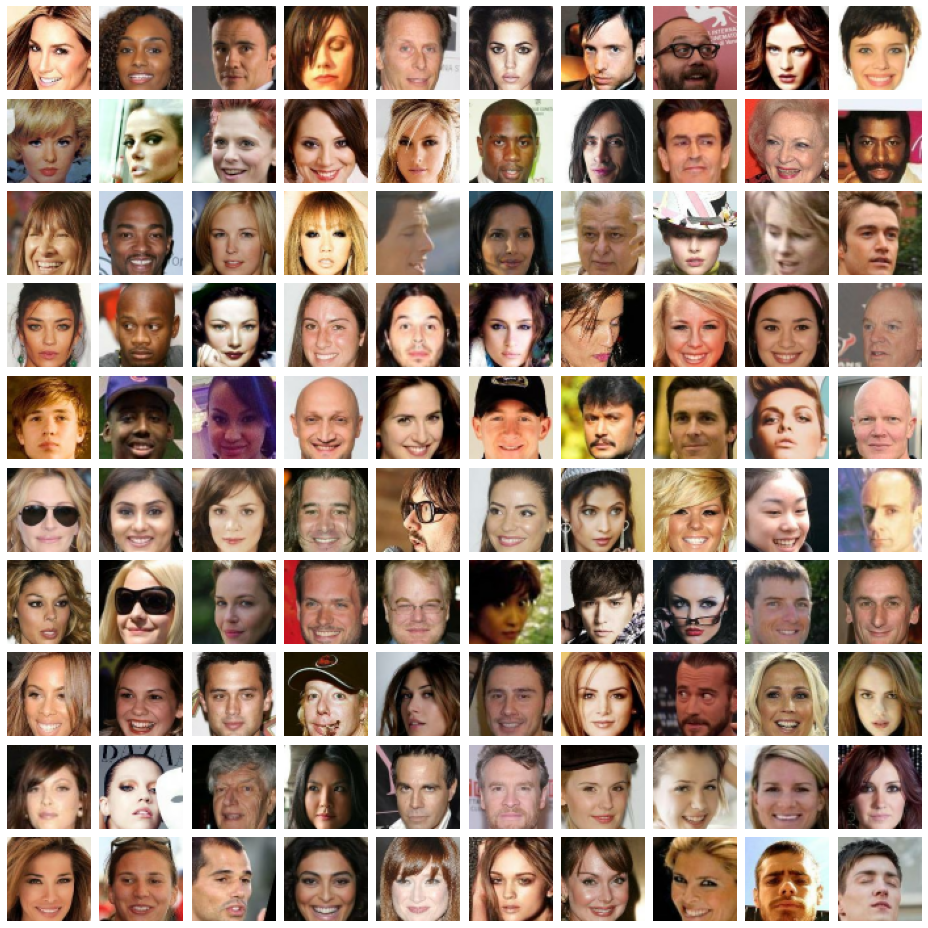

In [5]:
# Re-run this cell to show a new batch of images
name, images, attr = next(training_viz_iterator)
print('Image name {}\n'.format(name[0]))
for name in attr.keys():
  print('{}: {}\n'.format(name, attr[name][0]))
display_images(images, 10)

## Model


In [ ]:
def create_generator():
  return model

In [ ]:
def create_discriminator():
  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  generator = create_generator()
  discriminator = create_discriminator()
generator.summary()
discriminator.summary()

## Training

In [ ]:
def train():

## Results